# Test Yolo Inference

In [1]:
import services.ai_services.my_models as Models
import services.image_handler.utils as IMUtils
import services.ai_services.inferences as INF

In [ ]:
yolo = Models.YOLOv8(Models.YoloType.Custom.Plate_best)

In [ ]:
image = IMUtils.read_image('C:/Users/Alireza/Desktop/plate/2171038_FRONT.jpg')
image_rgb = IMUtils.convert_to_rgb(image)
image2 = IMUtils.read_image('C:/Users/Alireza/Desktop/plate/2170593_FRONT.jpg')
image_rgb2 = IMUtils.convert_to_rgb(image2)
IMUtils.show_image(image_rgb)
IMUtils.show_image(image_rgb2)
images = [image, image2]

In [6]:
inference = INF.YOLOInference(yolo)

In [ ]:
cropped_out = inference.run_full_pipeline(images)
for i in cropped_out:
    IMUtils.show_image(i, turn_grey=True, cmap='grey')

# Get and Save Plates

In [17]:
import services.image_handler.utils as IMUtils
import services.ai_services.inferences as INF
import services.ai_services.my_models as Models

In [18]:
images = IMUtils.read_images_from_file("C:/Users/Alireza/Desktop/cars/")

Reading images: 100%|██████████| 100/100 [00:02<00:00, 39.95file/s]


In [19]:
model = Models.YOLOv8(Models.YoloType.Custom.Plate_best)
inference = INF.YOLOInference(model)

Loading YOLO model from weights/best(plate).pt ...
YOLO: weights/best(plate).pt
Layer (type:depth-idx)                                       Param #
YOLO                                                         --
├─DetectionModel: 1-1                                        --
│    └─Sequential: 2-1                                       --
│    │    └─Conv: 3-1                                        (1,392)
│    │    └─Conv: 3-2                                        (41,664)
│    │    └─C2f: 3-3                                         (111,360)
│    │    └─Conv: 3-4                                        (166,272)
│    │    └─C2f: 3-5                                         (813,312)
│    │    └─Conv: 3-6                                        (664,320)
│    │    └─C2f: 3-7                                         (3,248,640)
│    │    └─Conv: 3-8                                        (1,991,808)
│    │    └─C2f: 3-9                                         (3,985,920)
│    │    └─SPPF:

In [20]:
cropped_out = inference.run_full_pipeline(images, conf=0.6, batch_size=64)

Running full pipeline ... 

conf=0.6, show=False, save=False
Running inference on Image

0: 416x640 1 plate, 13.7ms
1: 416x640 1 plate, 13.7ms
2: 416x640 1 plate, 13.7ms
3: 416x640 1 plate, 13.7ms
4: 416x640 1 plate, 13.7ms
5: 416x640 1 plate, 13.7ms
6: 416x640 1 plate, 13.7ms
7: 416x640 1 plate, 13.7ms
8: 416x640 1 plate, 13.7ms
9: 416x640 1 plate, 13.7ms
10: 416x640 1 plate, 13.7ms
11: 416x640 1 plate, 13.7ms
12: 416x640 1 plate, 13.7ms
13: 416x640 1 plate, 13.7ms
14: 416x640 2 plates, 13.7ms
15: 416x640 1 plate, 13.7ms
16: 416x640 1 plate, 13.7ms
17: 416x640 1 plate, 13.7ms
18: 416x640 1 plate, 13.7ms
19: 416x640 1 plate, 13.7ms
20: 416x640 1 plate, 13.7ms
21: 416x640 1 plate, 13.7ms
22: 416x640 1 plate, 13.7ms
23: 416x640 1 plate, 13.7ms
24: 416x640 1 plate, 13.7ms
25: 416x640 1 plate, 13.7ms
26: 416x640 1 plate, 13.7ms
27: 416x640 1 plate, 13.7ms
28: 416x640 1 plate, 13.7ms
29: 416x640 1 plate, 13.7ms
30: 416x640 1 plate, 13.7ms
31: 416x640 3 plates, 13.7ms
32: 416x640 1 plate, 13

In [21]:
output_dir = "C:/Users/Alireza/Desktop/plates/"
IMUtils.save_cropped_images(cropped_out, output_dir)

Saving images: 100%|██████████| 128/128 [00:00<00:00, 681.45file/s]

Files were saved successfully in C:/Users/Alireza/Desktop/plates/ 



# Training ResNet

In [1]:
from services.ai_services.my_models import Plate_ResNet
import services.ai_services.utils as AIUtils
from torch.utils.data import DataLoader

In [2]:
device = AIUtils.select_device()
res = Plate_ResNet(device=device)

NVIDIA GeForce GTX 1660 Ti have been located and selected
Selected model is ResNetType.Base
ResNet50
Layer (type:depth-idx)                        Param #
CustomResNet                                  --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3

In [3]:
res.freeze_unfreeze(True)
res.write_summary()

Start freezing feature extractor ...
Feature extractor freezed
Model is in cuda
Layer (type:depth-idx)                        Param #
CustomResNet                                  --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8 

In [4]:
batch = 64

train_dataset = AIUtils.CustomResNetDataset("C:/Users/Alireza/Desktop/plate_data/train/images",
                                            "C:/Users/Alireza/Desktop/plate_data/train/labels")
train_loader = DataLoader(train_dataset, batch, shuffle=True)

valid_dataset = AIUtils.CustomResNetDataset("C:/Users/Alireza/Desktop/plate_data/valid/images",
                                            "C:/Users/Alireza/Desktop/plate_data/valid/labels")
valid_loader = DataLoader(valid_dataset, batch, shuffle=True)

In [7]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
lr=5e-4
weight_decay=1e-5
optimizer = optim.Adam(res.model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.MSELoss()

res.train(train_loader,
          valid_loader,
          optimizer,
          weight_decay=weight_decay,
          lr=lr,
          epochs=500,
          loss_fn=criterion)

Starting training process for model ResNetType.Base ...
Hyper Parameters:
- Epochs Number = 500
- Learning Rate = 0.0005
- Weight Decay = 1e-05
- Loss Function = MSELoss()
- Optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
) 



Training Summary for 500 number of epochs:
    last epoch: Train loss=0.009673, Val loss=1.997817
    best epoch: Train loss=0.176654, Val loss=1.605813

Training completed
Training time: 133 minutes and 7.02 seconds


In [12]:
his = res.model_training_history

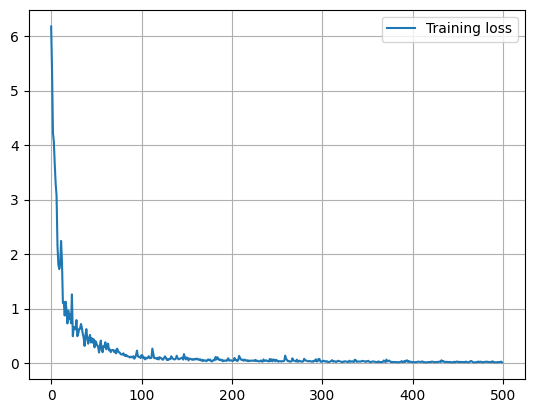

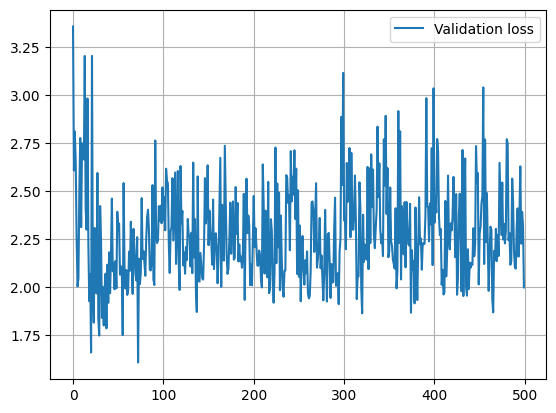

In [13]:
plt.plot(his['train_loss'], label='Training loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(his['valid_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.show()

# Test ResNet Inference

In [14]:
from services.image_handler.utils import read_image, convert_to_rgb, show_image
import services.ai_services.inferences as INF
from services.ai_services.my_models import Plate_ResNet
from services.ai_services.model_handler import ResNetType

In [17]:
res = Plate_ResNet(ResNetType.Corner_best)

Selected model is ResNetType.Corner_last
ResNet50
Layer (type:depth-idx)                        Param #
CustomResNet                                  --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   1,512,448
│    │    └─Bottlene

In [23]:
a = read_image("C:/Users/Alireza/Desktop/plate_data/valid/images/cropped_image_52_jpg.rf.52ea75aba93a07e48d2d6fbc03b235b2.jpg")
b = read_image("C:/Users/Alireza/Desktop/plate_data/train/images/cropped_image_11_jpg.rf.4e9c056f0360fd512d6d598f69d5af0e.jpg")
a = convert_to_rgb(a)
b = convert_to_rgb(b)

In [24]:
inference = INF.PlateResNetInference(res)

In [25]:
results = inference.run_full_pipeline([a,b])

Prepairing Images ... 

Running full pipeline ... 

Running inference on Image Batch
Outputs Generated
Corner points found for batch 0 

Rectified images in batch 1 appended to the results 



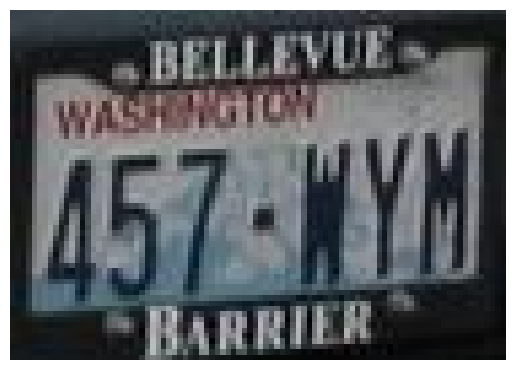

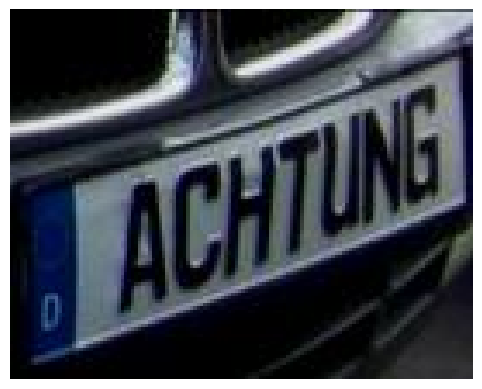

In [26]:
for i in [a, b]: show_image(i)

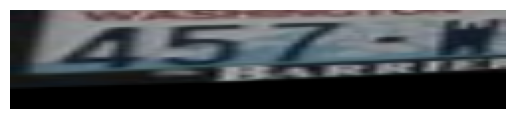

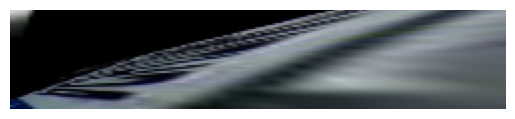

In [27]:
for i in results: show_image(i)

# test